NOTE: Please pip install the following (only used to reduce code):

pip install import_ipynb

In [374]:
# import a custom plotting library
import some_plotters as plotter

# import autograd functionality
import autograd.numpy as np

# import path to datasets
datapath = 'datasets/'

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

# autoreload functi"on - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### <span style="color:#a50e3e;">Exercise 1: </span>  Perform Imitation Learning on a small chunk of cruise control data 

In this exercise you will perform Imitation Learning using a small snippet of cruise control data shown below.  Here our `output sequence` are states $\left\{s_t\right\}_{t=1}^T$, and the `input sequence` corresponding actions $\left\{a_t\right\}_{t=1}^{T-1}$ (we can ignore any finanl action $a_T$ since there is no next state $s_{t+1}$ to regress it on in learning our system model).  Notice at each update step the action is clipped to lie in the range $[-50,100]$ - which is the angle of the pedal against the floor of the car.  Here a negative angle indicates that 'regenerative braking' was applied.

In [375]:
import autograd.numpy as np
from autograd import value_and_grad 
from autograd.misc.flatten import flatten_func
import matplotlib.pyplot as plt

# pip install import_ipynb
import import_ipynb
import homework_1_helper_functions

In [531]:
# load in cruise control data
data = np.loadtxt(datapath + 'simulated_car_data.csv',delimiter = ',')

# extract actions and states 
actions = data[0,1:][np.newaxis,:] # our T-1 actions
# actions = actions.T
states = data[1,:][np.newaxis,:]   # our T states
# states = states.T

# plot the test pair
# plotter.plot_pair(actions,states)

Some more particulars: here you need to learn the weights of a basic order $1$ linear system model - which takes the form

\begin{equation}
s_{t+1} = f_{\text{imitator}}\left(s_t,a_t\right) = w_0 + w_1s_t + w_2a_t
\end{equation}

by properly minimizing the associated Least Squares cost function

\begin{equation}
\frac{1}{T-1}\sum_{t=1}^{T-1}\left(f_{\text{imitator}}\left(s_t,a_t\right) - s_{t+1}\right)^2
\end{equation}

over the weights $\left\{ w_0,\, w_1,\, w_2\right\}$ where $T$ is the length of our training action sequence.  


- Build a `Python` version of the system model and Least Squares cost function and minimize it using a first order method.  Use the entire dataset provided for training (i.e., do not worry about validation error)


- After properly minimizing the Least Squares cost above make a plot like the one shown below - which shows the original state data in black, and the system model approximation in blue.  Your trained model should be able to match the data quite well.

<figure>
<p>
<img src= 'images/cruise_control_approximate.png' width="150%" height="150%" alt=""/>
</p>
</figure>

In [377]:
# watch order
def ord1func(w,s,a):
    fsa = w[0] + w[1]*s + w[2]*a
    return fsa

def LSfunc(w,s,a):
    T = len(s)
    s_0 = s[0:T-1]
    s_1 = s[1:T]
    cost = (0 + (np.sum(ord1func(w,s_0,a) - s_1)**2))/(0 + T-1)
    return cost

In [378]:
# homework_1_helper_functions.gradient_descent(g,w_init,alpha,max_its,verbose)
# homework_1_helper_functions.standard_normalizer(x)

In [519]:
# actions
a_normalizeR,a_inverse_normalizeR = homework_1_helper_functions.standard_normalizer(actions)
a_normalizeD = a_normalizeR(actions.T)

# states
s_normalizeR,s_inverse_normalizeR = homework_1_helper_functions.standard_normalizer(states)
s_normalizeD = s_normalizeR(states.T)

g = lambda w,s=s_normalizeD,a=a_normalizeD: LSfunc(w,s,a)

#randn(2,1) is out of bounds
w_hist,train_hist = homework_1_helper_functions.gradient_descent(g,
                                                                 w_init=.5*np.random.randn(3,1),
                                                                 alpha=10**(-1),
                                                                 max_its=100,
                                                                 verbose=False)

# index of the minimum cost value attained
ind = np.argmin(train_hist)

# corresponding weights and cost evaluation
w_best = w_hist[ind]
print("Best weights:\n" + str(w_best))
g_best = train_hist[ind]
print("\nBest cost:\n" + str(g_best))



Best weights:
[[0.1715823 ]
 [0.93787464]
 [0.00940438]]

Best cost:
[16.96295624]


/Users/ikhlas/anaconda3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)


<IPython.core.display.Javascript object>


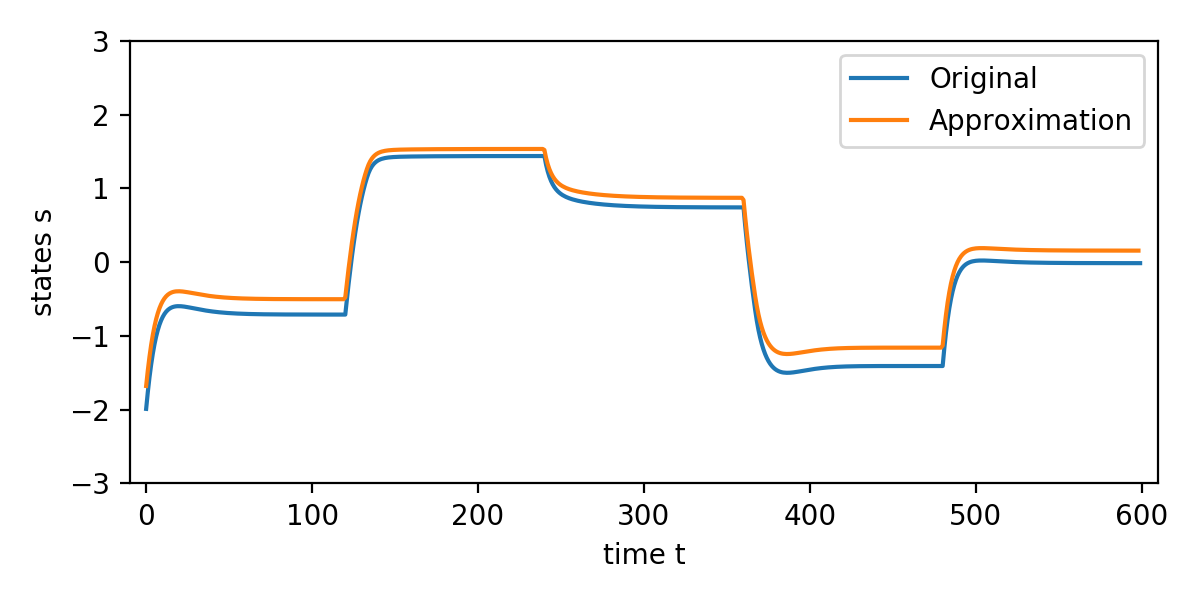

In [536]:
model1 = ord1func(w=w_best,
                  s=s_normalizeD[:599],
                  a=a_normalizeD)

plt.figure(figsize = (6,3))
plt.ylabel("states s")
plt.xlabel("time t")
axes = plt.gca()
axes.set_xlim([-10,610])
axes.set_ylim([-3,3])
plt.plot(s_normalizeD)
plt.plot(model1)
plt.legend(["Original", "Approximation"])
plt.show()